# Amazon-Flex Data Science Techniques (Part V) - Juan Moctezuma

The following script generates an elbow method plot (for the sum of squared distances) and a cluster analysis. The data comes from the ON-TIME_DELIVERY_ANALYSIS.csv which contains 2021 data from the RDF (Raw Data File) CSV file. 

The cluster analysis classifies the performance of each block based on a 'shift duration vs. total packages' plot. Random centroids are created based on current data and these classify each data point into clusters. How do we know how many clusters do we need? By looking at the 'elbow' plot and visually estimating 'k' number of clusters by observing the segments on the graph. Please note that as an Amazon contractor, you are randomly assigned deliveries in which the number of given boxes or envelops will be different every block.      

No historical data (incomplete information compiled on year 2020; which exists prior to the creation of this project) is included for this model. 

...

## 1. Before performing the Cluster Analysis

The first step is to install the required libraries.

In [ ]:
#!pip install pandas

In [ ]:
#!pip install numpy

In [ ]:
#!pip install matplotlib

In [ ]:
#!pip install scipy

In [ ]:
#!pip install seaborn

In [ ]:
#!pip install sklearn

Then import the libraries that you installed.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from sklearn.cluster import KMeans
#from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

We need to get our data. Once the delivery data csv is placed on the correct folder, you may use pandas to read the file and create dataframe. A common practice is to print the data from your csv to make sure everything is loaded correctly.

In [2]:
data = pd.read_csv("Data/ON-TIME_DELIVERY_ANALYSIS.csv")
data['DATE'] = pd.to_datetime(data['DATE'], infer_datetime_format = True)

df = pd.DataFrame(data, columns= ['DURATION_DIFFERENCE','TOTAL_PKGS'])
df.dtypes

DURATION_DIFFERENCE    float64
TOTAL_PKGS               int64
dtype: object

A common practice is to display the data from your csv to make sure everything is loaded correctly. 

In [3]:
display(df)

DURATION_DIFFERENCE  TOTAL_PKGS
0                   0.0          54
1                   1.0          38
2                   2.5          33
3                   1.0          40
4                   0.5          30
5                   1.5          39
6                   1.5          31
7                   0.5          46
8                  -0.2          26
9                  -0.1          28
10                  0.5          25

We use 'describe' to see the numerical data's basic statistics.

In [4]:
df.describe()

DURATION_DIFFERENCE  TOTAL_PKGS
count            11.000000   11.000000
mean              0.790909   35.454545
std               0.816645    8.970659
min              -0.200000   25.000000
25%               0.250000   29.000000
50%               0.500000   33.000000
75%               1.250000   39.500000
max               2.500000   54.000000

The following script generates the original (basic) On-Time Delivery Analysis (scatter plot). Data gets updated on a weekly basis.

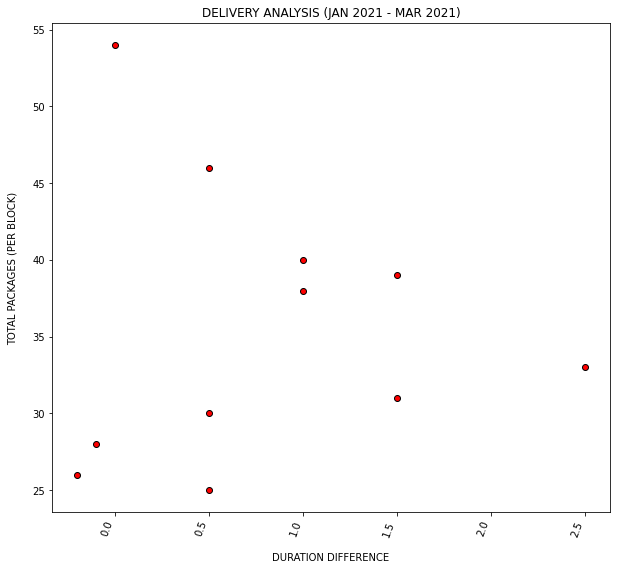

In [5]:
fig, ax = plt.subplots()
duration_difference = data['DURATION_DIFFERENCE']
tot_pkgs = data['TOTAL_PKGS']

plt.scatter(duration_difference, tot_pkgs, color = 'red', edgecolor = 'black', linewidth = 1, marker = 'o')

plt.title('DELIVERY ANALYSIS (JAN 2021 - MAR 2021)')
plt.xlabel("DURATION DIFFERENCE", labelpad = 15)
plt.gcf().autofmt_xdate(rotation = 70)
plt.ylabel("TOTAL PACKAGES (PER BLOCK)", labelpad = 15)
plt.gcf().set_size_inches((10, 10))
plt.show()

## 2. Elbow Method For Optimal k

In [6]:
mms = StandardScaler()
mms.fit(df)
normalized_data = mms.transform(df)

In [7]:
plt.figure(figsize=(8,5))

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

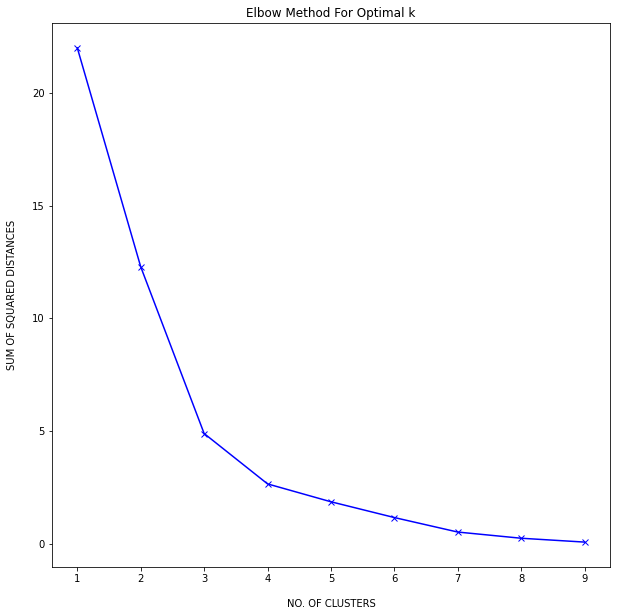

In [8]:
K = range(1,10)
Sum_of_squared_distances = []
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(normalized_data)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('NO. OF CLUSTERS', labelpad = 15)
plt.ylabel('SUM OF SQUARED DISTANCES', labelpad = 15)
plt.title('Elbow Method For Optimal k')
plt.gcf().set_size_inches((10, 10))
plt.show()

Notice the marker (cross) or 'elbow joint' is k=3, but based on our needs we may pick k=2, because we may decide how many clusters we need to classify our data points. In this project we only need 2 categories for completed blocks: 'Outstanding Performance' or 'Average Performance'.

## 2. Cluster Analysis

Our first step is to create k-number of centroids (two since that's the number of clusters we need). Centroids are NOT part of the dataset, but 2 points created randomly based on the average distance among data points. The blue and red 'x' are centroids.

In [9]:
duration_difference = np.array(data['DURATION_DIFFERENCE'])
duration_difference = list(duration_difference)

tot_pkgs = np.array(data['TOTAL_PKGS'])
tot_pkgs = list(tot_pkgs)

Numbers in the x-axis were extracted from the difference between the shift's duration and 3 (official block duration determined by Amazon). Negative numbers in the x-axis represent blocks that were completed BEFORE the assigned 3-hour schedule established by Amazon. Most blocks are supposed to last 3 hours but depending on the route, traffic, and other factors, Amazon allows contractors to continue delivering after the shift was officially over. Zero on the x-axis represents blocks that were completed exactly during 3 hours. All positive numbers represent the time difference after the shift was supposed to be completed. 

In [10]:
# CENTROID ASSIGNMENT
df_v2 = pd.DataFrame({
    'x': duration_difference,
    'y': tot_pkgs
})

np.random.seed(12)
k = 2
# centroids[i] = [x, y]
centroids = {
    i+1: [np.random.randint(-1, 2), np.random.randint(25, 54)]
    for i in range(k)
}

fig = plt.figure(figsize=(5, 5))
plt.scatter(df_v2['x'], df_v2['y'], color='k')
colmap = {1: 'b', 2: 'r'}
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i], marker='x')

plt.xlabel('DURATION DIFFERENCE (HOURS)', labelpad = 15)
plt.ylabel('TOTAL PACKAGES (PER ROUTE)', labelpad = 15)
plt.title('DELIVERY ANALYSIS (JAN 2021 - MAR 2021)')
plt.xlim(-1, 3)
plt.ylim(15, 60)
plt.gcf().set_size_inches((10, 10))
plt.show()

In [11]:
# ASSIGNMENT STAGE
def assignment(df, centroids):
    for i in centroids.keys():
        # sqrt((x1 - x2)^2 - (y1 - y2)^2)
        df['distance_from_{}'.format(i)] = (
            np.sqrt(
                (df['x'] - centroids[i][0])**2 + (df['y'] - centroids[i][1])**2
            )
        )
    centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]
    df['closest'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
    df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    df['color'] = df['closest'].map(lambda x: colmap[x])
    return df

df_v3 = assignment(df_v2, centroids)
print(df_v3.head())

fig = plt.figure(figsize=(5, 5))
plt.scatter(df_v3['x'], df_v3['y'], color=df_v3['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i], marker='x')

plt.xlabel('DURATION DIFFERENCE (HOURS)', labelpad = 15)
plt.ylabel('TOTAL PACKAGES (PER ROUTE)', labelpad = 15)
plt.title('PERFORMANCE CLUSTER ANALYSIS')
plt.xlim(-1, 3)
plt.ylim(15, 60)
plt.gcf().set_size_inches((10, 10))
plt.show()

# BLUE STANDS FOR OUTSTANDING PERFORMANCE
# RED STANDS FOR AVERAGE PERFORMANCE
'''How is performance measured in this analysis?
The greater the number of delivered packages per block relative to the time difference, the better! 
For example, observe data points where time difference was 0.5 hrs, blue data points mean MORE boxes 
or envelopes were delivered despite finishing 30 minutes later, unlike those blocks (red points) where 
LESS products were delivered and still finished half hour later.'''

     x   y  distance_from_1  distance_from_2  closest color
0  0.0  54        12.041595        26.019224        1     b
1  1.0  38         4.000000        10.000000        1     b
2  2.5  33         9.124144         5.220153        2     r
3  1.0  40         2.000000        12.000000        1     b
4  0.5  30        12.010412         2.061553        2     r


'How is performance measured in this analysis?\nThe greater the number of delivered packages per block relative to the time difference, the better! \nFor example, observe data points where time difference was 0.5 hrs, blue data points mean MORE boxes \nor envelopes were delivered despite finishing 30 minutes later, unlike those blocks (red points) where \nLESS products were delivered and still finished half hour later.'

In [12]:
df_v3.dtypes

x                  float64
y                    int64
distance_from_1    float64
distance_from_2    float64
closest              int64
color               object
dtype: object

## 3. Conclusion

In [ ]:
# The analysis successfully classified 2 different categories. This machine learning technique is considered an 
# unsupervised method. We may control the number of centroids that we need to produce clusters, but the user or 
# developer can’t determine how every single data point will be labelled, since the system (or Python’s script 
# modules) does.

In [ ]:
# How is performance measured in the cluster analysis? The greater the number of delivered packages per block 
# relative to the time difference, the better! For example, the case in which blue or red data points (blocks) 
# had a time difference of 0.5 hours; blue data points mean MORE boxes or envelopes were delivered despite finishing 
# 30 minutes after the schedule was over, unlike those blocks (red points) where LESS products were delivered and 
# still finished half hour later.

In [ ]:
# NOTE: Completing blocks after the assigned schedule (3 hours) don’t necessarily result on late-deliveries or 
# poor performance.